In [166]:
from bot import get_historical_data
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, precision_score
from itertools import combinations

In [167]:
TRANSACTION_COSTS = 0.0005
# Start investment is EURO!

In [168]:
# Fetch Bitcoin prices at 5-minute intervals for the last 40 days
symbol = 'BTCEUR'
days = 10000

bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
#bitcoin_data_5minute = get_historical_data(symbol, Client.KLINE_INTERVAL_5MINUTE, days)

In [169]:
bitcoin_data_hour["Open time"]

0       2020-01-03 09:00:00+01:00
1       2020-01-03 10:00:00+01:00
2       2020-01-03 11:00:00+01:00
3       2020-01-03 12:00:00+01:00
4       2020-01-03 13:00:00+01:00
                   ...           
40411   2024-08-14 13:00:00+02:00
40412   2024-08-14 14:00:00+02:00
40413   2024-08-14 15:00:00+02:00
40414   2024-08-14 16:00:00+02:00
40415   2024-08-14 17:00:00+02:00
Name: Open time, Length: 40416, dtype: datetime64[ns, Europe/Berlin]

In [170]:
bitcoin_data_hour.shape

(40416, 12)

In [171]:
bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1)    #time shift ist WICHTIG! einer der häufigsten Fehler, wenn er vergessen wird
#bitcoin_data_5minute["pct"] = bitcoin_data_5minute["Close"].pct_change().shift(-1)

In [172]:
bitcoin_data_hour.dropna(inplace=True)
#bitcoin_data_5minute.dropna(inplace=True)

df_hour = bitcoin_data_hour
#df_5minute = bitcoin_data_5minute


In [173]:
def sharpe_ratio(s):
    s = np.log(1+s)
    sharpe = s.mean() / s.std()
    print(f"mean={s.mean():.6f}, std={s.std():.6f}")
    return sharpe

In [174]:
#Funktion um zu zählen wie häufig ein buy Signal hinter einander auftritt
def count_consecutive_ones(data: pd.DataFrame, signal_col: str):
    new_column_name = signal_col + "_count"
    
    count = 0
    counts = []
    
    for value in data[signal_col]:
        if value == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    
    data[new_column_name] = counts

### Indikatoren und Indexe berechnen

In [175]:
def OBV_berechnen(data:pd.DataFrame):
    #benötigt ein DataFrame mit den Spalten "4a. close (EUR)" und "5. volume"
    data["OBV"] = (np.sign(data["Close"].pct_change()) * data["Volume"]).cumsum()
    
def SMA_berechnen(data:pd.DataFrame, intervall:int):
    spalten_name = "SMA_"+str(intervall)
    data[spalten_name] = data["Close"].rolling(intervall).mean()
    spalten_name_sig = "SMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    print(data[spalten_name_sig].mean())
    count_consecutive_ones(data, spalten_name_sig)
    
def RSI_berechnen(data:pd.DataFrame, intervall:int):

    spalten_name = "RSI_"+str(intervall)

    # Bestimme die Preisänderung zum jeweiligen Zeitpunkt t-1
    delta = data["Close"].diff()

    # Get rid of the first row, which has NaN values
    delta = delta[1:]

    # Calculate the gains and losses
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the rolling average of the gains and losses
    #window_size = 14 #als default
    avg_gain = up.rolling(intervall).mean()
    avg_loss = down.rolling(intervall).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss

    # Calculate the RSI
    data[spalten_name] = 100 - (100 / (1 + rs))
    
def EMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "EMA_" + str(intervall)
    data[spalten_name] = data["Close"].ewm(span=intervall, adjust=False).mean()
    spalten_name_sig = "EMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def HMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "HMA_" + str(intervall)
    half_length = int(intervall / 2)
    sqrt_length = int(np.sqrt(intervall))

    wma_half = data["Close"].rolling(window=half_length).mean()
    wma_full = data["Close"].rolling(window=intervall).mean()

    raw_hma = 2 * wma_half - wma_full
    data[spalten_name] = raw_hma.rolling(window=sqrt_length).mean()
    
    spalten_name_sig = "HMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def MACD_berechnen(data: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
    data["MACD"] = data["Close"].ewm(span=fast_period, adjust=False).mean() - data["Close"].ewm(span=slow_period, adjust=False).mean()
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_period, adjust=False).mean()

def Momentum_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "Momentum_" + str(intervall)
    data[spalten_name] = data["Close"].diff(intervall)

def Stochastic_RSI_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "StochRSI_" + str(intervall)

    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=intervall).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=intervall).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    min_RSI = RSI.rolling(window=intervall).min()
    max_RSI = RSI.rolling(window=intervall).max()

    data[spalten_name] = (RSI - min_RSI) / (max_RSI - min_RSI)

In [176]:
indicators = []
dt_indicators = []
OBV_berechnen(df_hour)
MACD_berechnen(df_hour)
dt_indicators.extend([f'OBV', f'MACD'])
for i in [24, 24*7, 24*100]:#[5, 10, 20, 50, 100, 500, 1000]:
    SMA_berechnen(df_hour, i)
    RSI_berechnen(df_hour, i)
    EMA_berechnen(df_hour, i)
    HMA_berechnen(df_hour, i)
    Momentum_berechnen(df_hour, i)
    Stochastic_RSI_berechnen(df_hour, i)
    indicators.extend([f"RSI_{i}", f"EMA_{i}", f"HMA_{i}", f"Momentum_{i}", f"StochRSI_{i}"])
    dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    

0.5248298898923667
0.537498453544476
0.5841890387232463


<BarContainer object of 24 artists>

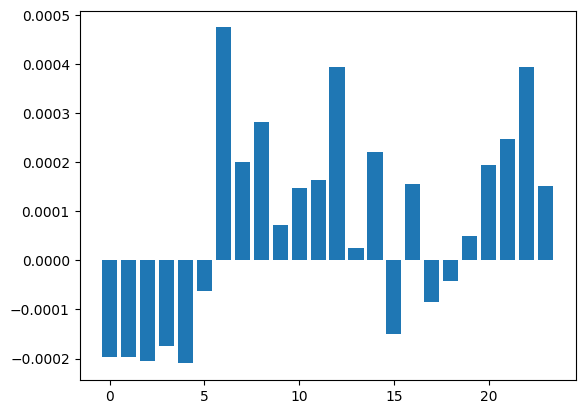

In [177]:
df_hour["Hour"] = df_hour["Open time"].dt.hour
tmp = df_hour.groupby("Hour")["pct"].mean()
plt.bar(x=tmp.index, height=tmp)

In [178]:
# Calendar Effects:
df_hour["Is_AfterHour"] = df_hour["Open time"].dt.hour >= 22
df_hour["Is_Monday"] = df_hour["Open time"].dt.day_of_week == 0
dt_indicators.extend([f'Is_AfterHour', f'Is_Monday'])

In [179]:
#berechnet performance für das gewollte Zeitfenster
def create_labels(data: pd.DataFrame, window: int):
    data["future_return"] = data["Close"].shift(-window) / data["Close"] - 1
    data["label"] = (data["future_return"] > TRANSACTION_COSTS*2).astype(int)
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

In [180]:
from sklearn import tree
def train_model(data: pd.DataFrame, features: list, target: str, param_grid, estimator):
    # Indizes zurücksetzen, um Probleme mit der Indizierung zu vermeiden
    data = data.reset_index(drop=True)
    
    # Aufteilen der Daten in Trainings- und Testdaten
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    X_train = train_data[features].dropna()
    X_test = test_data[features]
    y_train = train_data[target]
    
    # Definiere den Precision-Scorer
    precision_scorer = make_scorer(precision_score, pos_label=1)
    
    # Initialisiere den GridSearchCV
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                                cv=4,  # Anzahl der Cross-Validation-Folds
                                scoring=precision_scorer,  # Bewertungskriterium
                                n_jobs=-1,  # Nutze alle verfügbaren CPU-Kerne
                                verbose=2)  # Ausgabe von Fortschrittsinformationen

     # Führe GridSearch aus
    grid_search.fit(X_train, y_train)
    
    # Ausgabe der besten Parameter
    print("Beste Parameter:", grid_search.best_params_)
    
    # Modell mit den besten Parametern
    best_clf = grid_search.best_estimator_
    return best_clf, X_test, X_train
    
def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 
    
def evaluate_model(X_test, best_clf, data, signal_threshold, holding_period, plot=True):
    # Vorhersagen auf Testdaten
    #y_pred = best_clf.predict(X_test)
    
    #best_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    #best_clf.fit(X_train, y_train)
    
    # TODO print out sharpe ratio in training data set
    # y_pred_proba = best_clf.predict_proba(X_train)
    # y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    # y_pred = make_signals(y_pred, holding_period)
    # print(f"Sharpe Strategy (Train): {sharpe}")

    # Get the predicted probabilities
    y_pred_proba = best_clf.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    y_pred = make_signals(y_pred, holding_period)
    
    # Berechne die Sharpe Ratio
    test_returns = data.loc[X_test.index, "pct"]
    print(f'Sharpe BTC {sharpe_ratio(test_returns)}')

    strat_returns = test_returns.copy()
    strat_returns[y_pred == 0] = 0

    # Calculate transaction costs: a cost occurs whenever there is a change in the position (buy/sell)
    positions = np.diff(np.concatenate([[0], y_pred]))  # Calculate position changes
    transaction_costs = np.abs(positions) * TRANSACTION_COSTS  # Apply transaction costs

    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Ratio without costs: {sharpe}")
    strat_returns -= transaction_costs  # Deduct transaction costs from strategy returns

    print(f"number of transactions {np.sum(np.abs(positions))}")

    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Ratio with costs: {sharpe}")
    
    # Performance DataFrame erstellen
    if plot:
        # Performance DataFrame erstellen
        PF = pd.DataFrame(data["pct"].iloc[X_test.index])
        PF["pred"] = y_pred
        PF["strategy_returns"] = PF["pred"] * PF["pct"]
        PF["cumulative_strategy_returns"] = (PF["strategy_returns"] + 1).cumprod()

        PF["benchmark_returns"] = PF["pct"]
        PF["cumulative_benchmark_returns"] = (PF["benchmark_returns"] + 1).cumprod()

        # Calculate transaction indices
        transaction_indices = np.where(np.abs(positions) > 0)[0]

        # Adjust transaction_indices to match PF index
        transaction_indices = transaction_indices[transaction_indices < len(PF)]

        # Plot results
        plt.figure(figsize=(14, 7))
        plt.plot(PF["cumulative_strategy_returns"], label="Strategy Returns")
        plt.plot(PF["cumulative_benchmark_returns"], label="Benchmark Returns")

        # Add dots where transactions occur
        plt.scatter(PF.index[transaction_indices], PF["cumulative_strategy_returns"].iloc[transaction_indices],
                    color='red', marker='o', label='Transactions')

        plt.title("Cumulative Returns with Transactions")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.show()
    
    return sharpe

In [229]:
def find_best_indicators(data: pd.DataFrame, indicators: list, target: str, holding_period, signal_threshold, plot=True):
    best_sharpe = -np.inf
    best_combination = None
    best_model = None

    # Definiere den Parameterbereich für GridSearch
    param_grid = {
        #'criterion': ['gini', 'entropy'],
        'max_depth': [2, 3, 4],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [5, 10, 20, 30],
        'max_features': ['sqrt']
    }

    models = []
    train_sharpe_ratios = []
    test_sharpe_ratios = []
    combos = []
    for r in [1, 2, len(indicators)]:
        for combo in combinations(indicators, r):
            if len(train_sharpe_ratios) > 1000: 
                break
            print(combo)
            features = list(combo)
            clf, X_test, X_train = train_model(data, features, target, param_grid=param_grid, estimator=DecisionTreeClassifier(random_state=42))
            
            train_sharpe = evaluate_model(X_train, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)
            test_sharpe = evaluate_model(X_test, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)

            train_sharpe_ratios.append(train_sharpe)
            test_sharpe_ratios.append(test_sharpe)
            models.append(clf)
            combos.append(features)
            
            if test_sharpe > best_sharpe:
                best_sharpe = test_sharpe
                best_combination = combo
                best_model = clf

    print(f"Best Sharpe Ratio: {best_sharpe}")
    print(f"Best Indicator Combination: {best_combination}")

    return best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos

In [182]:
HOLDING_WINDOW = 24

In [183]:
# Labels erstellen
create_labels(df_hour, window=HOLDING_WINDOW)

In [230]:
#dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
# Liste der Indikatoren
features = dt_indicators#["SMA_50_Sig", "SMA_500_Sig", "HMA_50_Sig", "EMA_50_Sig", "EMA_500_Sig", "EMA_5_Sig"]#["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]

In [231]:
# Beste Indikatoren finden
best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(df_hour, 
                                                                                                                    features, 
                                                                                                                    holding_period=HOLDING_WINDOW, 
                                                                                                                    target="label", 
                                                                                                                    signal_threshold=0.55,
                                                                                                                    plot=False)

('OBV',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000048, std=0.002716
Sharpe Ratio without costs: 0.01782002870560015
number of transactions 46
mean=0.000048, std=0.002716
Sharpe Ratio with costs: 0.017525177247744377
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('MACD',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000012, std=0.002174
Sharpe Ratio without costs: 0.005474273809716774
number of transactions 28
mean=0.000011, std=0.002173
Sharpe Ratio with costs: 0.0052513506054831715
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000025, 

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000042, std=0.003190
Sharpe Ratio without costs: 0.0130291537997078
number of transactions 404
mean=0.000034, std=0.003192
Sharpe Ratio with costs: 0.010798346672222545
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000051, std=0.002351
Sharpe Ratio without costs: 0.021904311568075693
number of transactions 99
mean=0.000045, std=0.002351
Sharpe Ratio with costs: 0.01894010688740835
('SMA_24_Sig',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000014, std=0.002007
Sharpe Ratio without costs: 0.007219061924704571
number of transactions 26
mean=0.000014, std=0.002007
Sharpe Ratio with costs: 0.00699255339163913


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000046, std=0.001955
Sharpe Ratio without costs: 0.023374449666963778
number of transactions 14
mean=0.000045, std=0.001953
Sharpe Ratio with costs: 0.02289285140103214
('StochRSI_24',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000003, std=0.000394
Sharpe Ratio without costs: 0.007083913789478385
number of transactions 10
mean=0.000003, std=0.000393
Sharpe Ratio with costs: 0.006651469408892247
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_168',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000065, std=0.004289
Sharpe Ratio without costs: 0.015174737806550409
number of transactions 389
mean=0.000058, std=0.004289
Sharpe Ratio with costs: 0.013580797962554871
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000086, std=0.003808
Sharpe Ratio without costs: 0.022528658886127064
number of transactions 97
mean=0.000079, std=0.003809
Sharpe Ratio with costs: 0.020735039583605622
('SMA_168_Sig',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transa

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Mom

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000012, std=0.001705
Sharpe Ratio without costs: 0.0068156553853651655
number of transactions 14
mean=0.000011, std=0.001705
Sharpe Ratio with costs: 0.006671344583547912
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000000, std=0.001271
Sharpe Ratio without costs: -0.0002542563356905724
number of transactions 2
mean=-0.000000, std=0.001273
Sharpe Ratio with costs: -0.0003660419121089879
('StochRSI_168',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000001, std=0.004171
Sharpe Ratio without costs: 0.0002923083586921353
number of transactions 280
mean=-0.000004, std=0.004171
Sharpe Ratio with costs: -0.0008870069924459668
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000002, std=0.003720
S

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_2400',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000022, std=0.002264
Sharpe Ratio without costs: 0.00985687179651004
number of transactions 42
mean=0.000022, std=0.002265
Sharpe Ratio with costs: 0.009526779686561826
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000006, std=0.001828
Sharpe Ratio without costs: -0.0035391821344185103
number of transactions 6
mean=-0.000007, std=0.001828
Sharpe Ratio with costs: -0.0037702847781150217
('StochRSI_2400',)
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000023, std=0.003920
Sharpe Ratio without costs: 0.00585422505648593
number of transactions 208
mean=0.000019, std=0.003921
Sharpe Ratio with costs: 0.00492084490354471
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000018, std=0.002625
Sharpe Ra

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'MACD')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000048, std=0.004756
Sharpe Ratio without costs: 0.01003522823823054
number of transactions 200
mean=0.000044, std=0.004756
Sharpe Ratio with costs: 0.009295723767105206
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000052, std=0.003533
Sharpe Ratio without costs: 0.014828193392632158
number of transactions 64
mean=0.000051, std=0.003533
Sharpe Ratio with costs: 0.014509752131723393
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'EMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000026, std=0.001703
Sharpe Ratio without costs: 0.015457930302123566
number of transactions 68
mean=0.000025, std=0.001703
Sharpe Ratio with costs: 0.014756334544237895
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'HMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000050, std=0.002706
Sharpe Ratio without costs: 0.018310072748975642
number of transactions 46
mean=0.000049, std=0.002706
Sharpe Ratio with costs: 0.01801294087710752
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of tra

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'StochRSI_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000055, std=0.003659
Sharpe Ratio without costs: 0.015083951716796162
number of transactions 44
mean=0.000054, std=0.003659
Sharpe Ratio with costs: 0.014871707570632896
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'RSI_168')


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000008, std=0.001820
Sharpe Ratio without costs: 0.004386094579183352
number of transactions 34
mean=0.000007, std=0.001819
Sharpe Ratio with costs: 0.004059152516905534
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'SMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000041, std=0.004045
Sharpe Ratio without costs: 0.010245944317537442
number of transactions 114
mean=0.000039, std=0.004045
Sharpe Ratio with costs: 0.009751559516527087
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'EMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000043, std=0.004016
Sharpe Ratio without costs: 0.010630603277411733
number of transactions 116
mean=0.000041, std=0.004016
Sharpe Ratio with costs: 0.010122972648953612
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000047, std=0.002686
Sharpe Ratio without costs: 0.017623932436405254
number of transactions 58
mean=0.000046, std=0.002685
Sharpe Ratio with costs: 0.01724715794655272
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'StochRSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000030, std=0.005126
Sharpe Ratio without costs: 0.0057952135395904405
number of transactions 288
mean=0.000025, std=0.005126
Sharpe Ratio with costs: 0.004808527895510792
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000003, std=0.004009
Sharpe Ratio without costs: 0.0007788166857933863
number of transactions 72
mean=-0.000002, std=0.004010
Sharpe Ratio with costs: -0.00048353564659193104
('OBV', 'RSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000014, std=0.001003
Sharpe Ratio without costs: 0.014436721296048054
number of transactions 22
mean=0.000014, std=0.001003
Sharpe Ratio with costs: 0.014055593249581748
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'SMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000037, std=0.002137
Sharpe Ratio without costs: 0.01721078473108128
number of transactions 54
mean=0.000036, std=0.002137
Sharpe Ratio with costs: 0.016767257897227186
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'EMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000041, std=0.002095
Sharpe Ratio without costs: 0.019441104273862014
num

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000061, std=0.002883
Sharpe Ratio without costs: 0.02106707319548668
number of transactions 62
mean=0.000060, std=0.002883
Sharpe Ratio with costs: 0.020690817985772228
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('OBV', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000067, std=0.004606
Sharpe Ratio without costs: 0.01444887336598173
number of transactions 118
mean=0.000064, std=0.004606
Sharpe Ratio with costs: 0.013999091113859987
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000015, std=0.002085
Sharpe Ratio without costs: 0.006987349187756894
number of transactions 20
mean=0.000013, std=0.002084
Sharpe Ratio with costs: 0.006318255804611683
('OBV', 'Is_AfterHour')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000048, std=0.002716
Sharpe Ratio without costs: 0.01782002870560015
number of transactions 46
mean=0.000048, std=0.002716
Sharpe Ratio with costs: 0.017525177247744377
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe R

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000051, std=0.002668
Sharpe Ratio without costs: 0.019091600896219498
number of transactions 88
mean=0.000049, std=0.002668
Sharpe Ratio with costs: 0.018513374549474493
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('MACD', 'RSI_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000028, std=0.002575
Sharpe Ratio without costs: 0.011033799726308937
number of transactions 150
mean=0.000026, std=0.002574
Sharpe Ratio with costs: 0.0100126384370642
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000061, std=0.002285
Sharpe Ratio without costs: 0.026888917736777224
number of transactions 56
mean=0.000058, std=0.002285
Sharpe Ratio with costs: 0.025160375893963853
('MACD', 'SMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000012, std=0.002174
Sharpe Ratio without costs: 0.005474273809716774
number of transactions 28
mean=0.000011, std=0.002173
Sharpe Ratio with costs: 0.0052513506054831715
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000025, std=0.001769
Sharpe Ratio without costs: 0.014186974561071366
number of transac

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_24', 'HMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: n

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_24', 'StochRSI_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transact

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_24', 'EMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_24', 'HMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: 

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_24', 'StochRSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs:

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_24', 'SMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000057, std=0.004800
Sharpe Ratio without costs: 0.01183886021514433
number of transactions 416
mean=0.000050, std=0.004800
Sharpe Ratio with costs: 0.010314342635052971
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000073, std=0.004667
Sharpe Ratio w

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000018, std=0.001205
Sharpe Ratio without costs: 0.014752278538766655
number of transactions 24
mean=0.000017, std=0.001205
Sharpe Ratio with costs: 0.01440911425197888
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_24', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000001, std=0.002083
Sharpe Ratio without costs: 0.000377821895117801
number of transactions 76
mean=-0.000001, std=0.002082
Sharpe Ratio with costs: -0.00026279089860838393
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000009, std=0.000845
Sharpe Ratio without costs: -0.010

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'EMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'m

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000031, std=0.003916
Sharpe Ratio without costs: 0.007985614392883037
number of transactions 456
mean=0.000023, std=0.003916
Sharpe Ratio with costs: 0.005940320754282252
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000014, std=0.002752
Sharpe Ratio without costs: 0.005239936873127052
number of transactions 90
mean=0.000008, std=0.002751
Sharpe Ratio with costs: 0.00294255731015362
('SMA_24_Sig', 'RSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000064, std=0.003653
Sharpe Ratio without costs: 0.01739958158252716
number of transactions 367
mean=0.000057, std=0.003653
Sharpe Ratio with costs: 0.015631055513800823
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000049, std=0.003144
Sharpe Ratio without costs: 0.015626845360129527
number of tran

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with cos

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000002, std=0.003667
Sharpe Ratio without costs: 0.0005869393256132391
number of transactions 76
mean=0.000001, std=0.003667
Sharpe Ratio with costs: 0.00022275689298167882
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000017, std=0.002933
Sharpe Ratio without costs: 0.005865492471937927
number of transactions 48
mean=0.000014, std=0.002932
Sharpe Ratio with costs: 0.004716440056032395
('SMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000010, std=0.004452
Sharpe Ratio without costs: 0.002190003377263234
number of transactions 300
mean=0.000004, std=0.004452
Sharpe Ratio with costs: 0.0010064459550823478
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000001, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_24_Sig', 'Momentum_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000021, std=0.001508
Sharpe Ratio without costs: 0.013892432741390468
number of transactions 28
mean=0.000020, std=0.001508
Sharpe Ratio with costs: 0.01355767833993789
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000019, std=0.002991
Sharpe Ratio without costs: 0.006258078723025576
number of transactions 102
mean=0.000017, std=0.002991
Sharpe Ratio with costs: 0.00565886586610239
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000009, std=0.001258
Sharpe Ratio without costs: -0.00718905633327401
number of transactions 16
mean=-0.000010, std=0.001258
Sharpe Ratio with costs: -0.00808195055385913
('SMA_24_Sig', 'Is_AfterHour')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
m

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000014, std=0.002007
Sharpe Ratio without costs: 0.007219061924704571
number of transactions 26
mean=0.000014, std=0.002007
Sharpe Ratio with costs: 0.00699255339163913
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000046, std=0.001955
Sharpe Ratio without costs: 0.023374449666963778
number of transactions 

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'RSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000037, std=0.003086
Sharpe Ratio without costs: 0.011990048255452692
number of transactions 192
mean=0.000034, std=0.003085
Sharpe Ratio with costs: 0.010899183046846927
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000024, std=0.002730
Sharpe Ratio without costs: 0.008702567928866981
number of transactions 55
mean=0.000020, std=0.002731
Sharpe Ratio with costs: 0.007284707369205398
('EMA_24_Sig', 'SMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
num

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with cos

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000012, std=0.001705
Sharpe Ratio without costs: 0.0068156553853651655
number of transactions 14
mean=0.000011, std=0.001705
Sharpe Ratio with costs: 0.006671344583547912
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000000, std=0.001271
Sharpe Ratio without costs: -0.0002542563356905724
number of transactions 2
mean=-0.000000, std=0.001273
Sharpe Ratio with costs: -0.0003660419121089879
('EMA_24_Sig', 'StochRSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000009, std=0.004463
Sharpe Ratio without costs: 0.0020451999993967586
number of transactions 296
mean=0.000004, std=0.004462
Sharpe Ratio with costs: 0.0008801824248057288
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000002, std

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000054, std=0.004688
Sharpe Ratio without costs: 0.0116103833094233
number of transactions 244
mean=0.000050, std=0.004687
Sharpe Ratio with costs: 0.010698706938743113
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000054, std=0.004755
Sharpe Ratio without costs: 0.011376642831579173
number of transactions 78
mean=0.000049, std=0.004755
Sharpe Ratio with costs: 0.01022373793135325
('EMA_24_Sig', 'HMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'Momentum_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000021, std=0.001508
Sharpe Ratio without costs: 0.013892432741390468
number of transactions 28
mean=0.000020, std=0.001508
Sharpe Ratio with costs: 0.01355767833993789
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_24_Sig', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates,

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig', 'Momentum_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000030, std=0.004046
Sharpe Ratio without costs: 0.007321224686420472
number of transactions 264
mean=0.000025, std=0.004046
Sharpe Ratio with costs: 0.00617396923573864
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000061, std=0.003559
Sharpe Ratio without costs: 0.017253103670862826
number of transactions

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig', 'Momentum_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000023, std=0.002722
Sharpe Ratio without costs: 0.008383034302578288
number of transactions 96
mean=0.000021, std=0.002722
Sharpe Ratio with costs: 0.007761952135884376
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000015, std=0.002284
Sharpe Ratio without costs: -0.006562233290567727
number of transactions 38
mean=-0.000018, std=0.002285
Sharpe Ratio with costs: -0.007728278349135114
('HMA_24_Sig', 'StochRSI_168')
Fit

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig', 'HMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with co

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000019, std=0.001513
Sharpe Ratio without costs: 0.012516676365607509
number of transactions 28
mean=0.000018, std=0.001514
Sharpe Ratio with costs: 0.01218627473716683
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_24_Sig', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000015, std=0.004031
Sharpe Ratio without costs: 0.003685362785329503
number of transactions 240
mean=0.000011, std=0.004031
Sharpe Ratio with costs: 0.0026389982913586096
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000019, std=0.002409
Sharpe Ratio without costs: 0.008

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_24', 'StochRSI_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000011, std=0.004234
Sharpe Ratio without costs: 0.002505127834786508
number of transactions 496
mean=0.000002, std=0.004233
Sharpe Ratio with costs: 0.00044651387562195656
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000031, std=0.003361
Sharpe Ratio without costs: 0.009191484318792765
number of transactions 119
mean=0.000023, std=0.003360
Sharpe Ratio with costs: 0.006706667330070091
('Momentum_24', 'RSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000014, std=0.002007
Sharpe Ratio without costs: 0.007219061924704571
number of transactions 26
mean=0.000014, std=0.002007
Sharpe Ratio with costs: 0.00699255339163913
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000046, std=0.001955
Sharpe Ratio without costs: 0.023374449666963778
number of 

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000003, std=0.000394
Sharpe Ratio without costs: 0.007083913789478385
number of transactions 10
mean=0.000003, std=0.000393
Sharpe Ratio with costs: 0.006651469408892247
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('StochRSI_24', 'HMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000003, std=0.000394
Sharpe Ratio without costs: 0.007083913789478385
number of transactions 10
mean=0.000003, std=0.000393
Sharpe Ratio with costs: 0.006651469408892247
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
num

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000028, std=0.003340
Sharpe Ratio without costs: 0.008281993481701826
number of transactions 118
mean=0.000026, std=0.003339
Sharpe Ratio with costs: 0.00766197670525109
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000006, std=0.002691
Sharpe Ratio without costs: 0.00238153995603931
number of transactions 36
mean=0.000004, std=0.002690
Sharpe Ratio with costs: 0.0014426666007894332
('StochRSI_24', 'StochRSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000024, std=0.004177
Sharpe Ratio without costs: 0.005847560985436333
number of transactions 392
mean=0.000018, std=0.004177
Sharpe Ratio with costs: 0.004199351440202459
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000021, std=0.00381

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('StochRSI_24', 'SMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000003, std=0.000394
Sharpe Ratio without costs: 0.007083913789478385
number of transactions 10
mean=0.000003, std=0.000393
Sharpe Ratio with costs: 0.006651469408892247
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('StochRSI_24', 'EMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000013, std=0.001241
Sharpe Ratio without costs: 0.01043

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000017, std=0.001507
Sharpe Ratio without costs: 0.01146790271623236
number of transactions 36
mean=0.000017, std=0.001507
Sharpe Ratio with costs: 0.011047703991248738
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('StochRSI_24', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000007, std=0.003175
Sharpe Ratio without costs: 0.002180616321041472
number of transactions 110
mean=0.000005, std=0.003174
Sharpe Ratio with costs: 0.0015722032105051722
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000004, std=0.001575
Sharpe Ratio without costs: -0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('StochRSI_24', 'Is_Monday')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000003, std=0.000394
Sharpe Ratio without costs: 0.007083913789478385
number of transactions 10
mean=0.000003, std=0.000393
Sharpe Ratio with costs: 0.006651469408892247
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_168', 'SMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000011, std=0.002521
Sharpe Ratio without costs: 0.0041724313420

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_168_Sig', 'Momentum_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000012, std=0.001705
Sharpe Ratio without costs: 0.0068156553853651655
number of transactions 14
mean=0.000011, std=0.001705
Sharpe Ratio with costs: 0.006671344583547912
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000000, std=0.001271
Sharpe Ratio without costs: -0.0002542563356905724
number of transactions 2
mean=-0.000000, std=0.001273
Sharpe Ratio with costs: -0.0003660419121089879
('SMA_168_Sig', 'StochRSI_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000023, std=0.004585
Sharpe Ratio without costs: 0.004962625653126082
number of transactions 338
mea

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_168_Sig', 'HMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_168_Sig', 'Momentum_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000020, std=0.001603
Sharpe Ratio without costs: 0.01223651714088326
number of transactions 28
mean=0.000019, std=0.001604
Sharpe Ratio with costs: 0.011926015183396768
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_168_Sig', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidate

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_168_Sig', 'HMA_168_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of tra

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=-0.000000, std=0.004256
Sharpe Ratio without costs: -1.1628638566323423e-05
number of transactions 266
mean=-0.000005, std=0.004256
Sharpe Ratio with costs: -0.0011099521754750284
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000017, std=0.003630
Sharpe Ratio without costs: 0.004763895522223035
number of transactions 62
mean=0.000013, std=0.003629
Sharpe Ratio with costs: 0.0035657636704828164
('EMA_168_Sig', 'RSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000054, std=0.003470
Sharpe Ratio without costs: 0.01559515399780146
number of transactions 96
mean=0.000052, std=0.003470
Sharpe Ratio with costs: 0.01510884403904431
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000039, std=0.003

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_168_Sig', 'HMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with c

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000029, std=0.002291
Sharpe Ratio without costs: 0.012604120389110166
number of transactions 56
mean=0.000028, std=0.002291
Sharpe Ratio with costs: 0.012172297757927901
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000007, std=0.002200
Sharpe Ratio without costs: -0.003360285557108464
number of transactions 18
mean=-0.000009, std=0.002199
Sharpe Ratio with costs: -0.003935898166377436
('EMA_168_Sig', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000007, std=0.002898
Sharpe Ratio without costs: 0.0023590056971392625
number of transactions 80
mean=0.000005, std=0.002898
Sharpe Ratio with costs: 0.0018732860409366957
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000006, std=

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig', 'Momentum_168')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000007, std=0.005154
Sharpe Ratio without costs: 0.0014393479842348515
number of transactions 242
mean=0.000003, std=0.005154
Sharpe Ratio with costs: 0.0006141870716065437
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000057, std=0.004369
Sharpe Ratio without costs: 0.01303844912767243
number of transact

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_168_Sig', 'HMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with c

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000052, std=0.003737
Sharpe Ratio without costs: 0.014035224318872202
number of transactions 100
mean=0.000051, std=0.003737
Sharpe Ratio with costs: 0.013564277410813423
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000036, std=0.003933
Sharpe Ratio without costs: 0.009058865065785059
number of transactions 50
mean=0.000032, std=0.003933
Sharpe Ratio with costs: 0.008164279742691526
('HMA_168_Sig', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000030, std=0.003051
Sharpe Ratio without costs: 0.00969549388893911
number of transactions 132
mean=0.000027, std=0.003051
Sharpe Ratio with costs: 0.008935753756275557
mean=0.000095, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000019, std=0.004601
Sharpe Ratio without costs: 0.0041574143485122415
number of transactions 312
mean=0.000014, std=0.004602
Sharpe Ratio with costs: 0.0029657835454601155
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000011, std=0.004095
Sharpe Ratio without costs: 0.0026510858343779795
number of transactions 77
mean=0.000005, std=0.004096
Sharpe Ratio with costs: 0.0013284703634463366
('Momentum_168', 'RSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000012, std=0.001732
Sharpe Ratio without costs: 0.007183002979979853
number of transactions 16
mean=0.000012, std=0.001732
Sharpe Ratio with costs: 0.007021355049990811
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000000, std=0.001

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_2400', 'Momentum_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000005, std=0.000515
Sharpe Ratio without costs: 0.009905854614314476
number of transactions 4
mean=0.000005, std=0.000515
Sharpe Ratio with costs: 0.009768099420338575
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('RSI_2400', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000058, std=0.004414
Sharpe Ratio without costs: 0.0131296805

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000059, std=0.003874
Sharpe Ratio without costs: 0.015296161959663244
number of transactions 68
mean=0.000058, std=0.003874
Sharpe Ratio with costs: 0.014988701520171288
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000093, std=0.004055
Sharpe Ratio without costs: 0.022858227043321435
number of transactions 12
mean=0.000092, std=0.004054
Sharpe Ratio with costs: 0.02265858055946889
('SMA_2400_Sig', 'EMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000015, std=0.001292
Sharpe Ratio without costs: 0.011819288349708221
number of transactions 36
mean=0.000015, std=0.001293
Sharpe Ratio with costs: 0.011322732028654013
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000003, std=0.001294
Sharpe Ratio without costs: 0.0025986760515878966
number 

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('SMA_2400_Sig', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000010, std=0.003309
Sharpe Ratio without costs: 0.0029820997870964204
number of transactions 110
mean=0.000008, std=0.003309
Sharpe Ratio with costs: 0.0023977884932263683
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000008, std=0.001878
Sharpe Ratio without costs: 0.00414416412405243
number of transactions 28
mean=0.000006, std=0.001876
Sharpe Ratio with costs: 0.003100577807775337
('SMA_2400_Sig', 'Is_AfterHour')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_2400_Sig', 'HMA_2400_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with 

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000020, std=0.001560
Sharpe Ratio without costs: 0.01295490432836626
number of transactions 28
mean=0.000020, std=0.001561
Sharpe Ratio with costs: 0.012634352177004343
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('EMA_2400_Sig', 'StochRSI_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000010, std=0.003389
Sharpe Ratio without costs: 0.0028713339935823503
number of transactions 118
mean=0.000008, std=0.003389
Sharpe Ratio with costs: 0.0022594371702558003
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000012, std=0.001872
Sharpe Ratio without costs: 0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('HMA_2400_Sig', 'Momentum_2400')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000038, std=0.002303
Sharpe Ratio without costs: 0.016552202922877682
number of transactions 46
mean=0.000037, std=0.002303
Sharpe Ratio with costs: 0.016203975897819436
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=-0.000021, std=0.001611
Sharpe Ratio without costs: -0.012908982486218034
number of transa

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000020, std=0.001560
Sharpe Ratio without costs: 0.01295490432836626
number of transactions 28
mean=0.000020, std=0.001561
Sharpe Ratio with costs: 0.012634352177004343
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931


C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_2400', 'Is_AfterHour')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 3, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000020, std=0.001560
Sharpe Ratio without costs: 0.01295490432836626
number of transactions 28
mean=0.000020, std=0.001561
Sharpe Ratio with costs: 0.012634352177004343
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
('Momentum_2400', 'Is_Monday')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000020, std=0.001560
Sharpe Ratio without costs: 0.01295

C:\Users\Adria\AppData\Local\Temp\ipykernel_17756\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000013, std=0.002873
Sharpe Ratio without costs: 0.004629735766740073
number of transactions 53
mean=0.000010, std=0.002872
Sharpe Ratio with costs: 0.003335786494781702
('StochRSI_2400', 'Is_Monday')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 4, 'max_features': 'sqrt'}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000027, std=0.004281
Sharpe Ratio without costs: 0.0063705683329769525
number of transactions 248
mean=0.000023, std=0.004282
Sharpe Ratio with costs: 0.0053510127417979135
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000008, std=0.002987
Sharpe Ratio without costs: 0.002537673535617992
number of transactions 60
mean=0.000003, std=0.002987
Sharpe Ratio with costs: 0.0011260994819075392
('Is_AfterHour', 'Is_Monday')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 2, 'max_features': '

In [232]:
res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                              "train":train_sharpe_ratios})

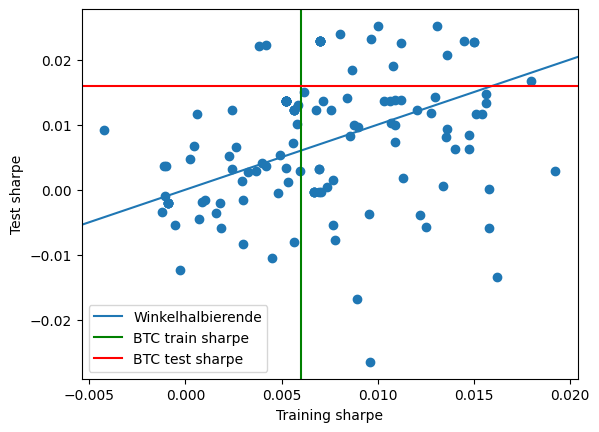

In [247]:
fig, ax = plt.subplots()

ax.scatter(train_sharpe_ratios, test_sharpe_ratios)
ax.axline((min(train_sharpe_ratios), min(train_sharpe_ratios)), slope=1, label="Winkelhalbierende")

train_btc_sharpe=0.006
test_btc_sharpe=0.016  
plt.axvline(x=train_btc_sharpe, color='g', linestyle='-', label="BTC train sharpe")
plt.axhline(y=test_btc_sharpe, color='r', linestyle='-', label="BTC test sharpe")

ax.set_xlabel("Training sharpe")
ax.set_ylabel("Test sharpe")
ax.legend()

In [258]:
# Indices which have above average training and test sharpe ratios
interesting_indices = [idx for idx, val in enumerate(test_sharpe_ratios) if val > test_btc_sharpe and train_sharpe_ratios[idx] > train_btc_sharpe]
res.iloc[interesting_indices].sort_values("test", ascending=False)

,test,train
43,0.025160,0.010013
225,0.025157,0.013091
49,0.023845,0.008057
137,0.023228,0.009649
144,0.022893,0.014476
6,0.022893,0.006993
139,0.022893,0.006993
135,0.022893,0.006993
134,0.022893,0.006993
138,0.022893,0.006993


In [272]:
idx=43
print(combos[idx])

['MACD', 'RSI_24']


In [273]:
models[idx]

DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=42)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000028, std=0.002575
Sharpe Ratio without costs: 0.011033799726308937
number of transactions 150
mean=0.000026, std=0.002574
Sharpe Ratio with costs: 0.0100126384370642


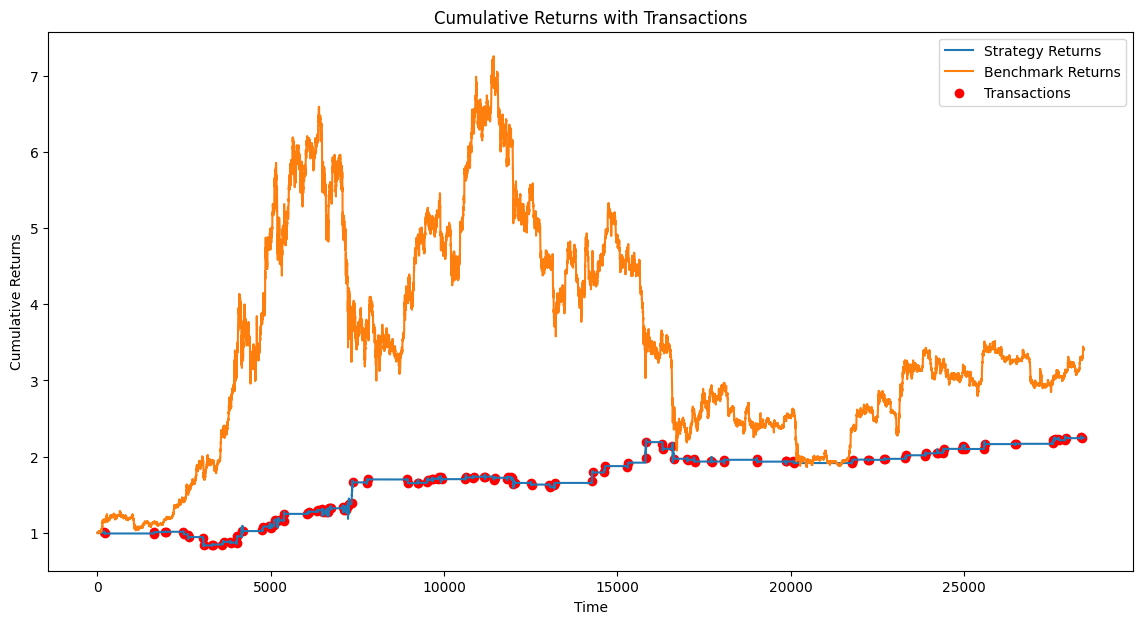

mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000061, std=0.002285
Sharpe Ratio without costs: 0.026888917736777224
number of transactions 56
mean=0.000058, std=0.002285
Sharpe Ratio with costs: 0.025160375893963853


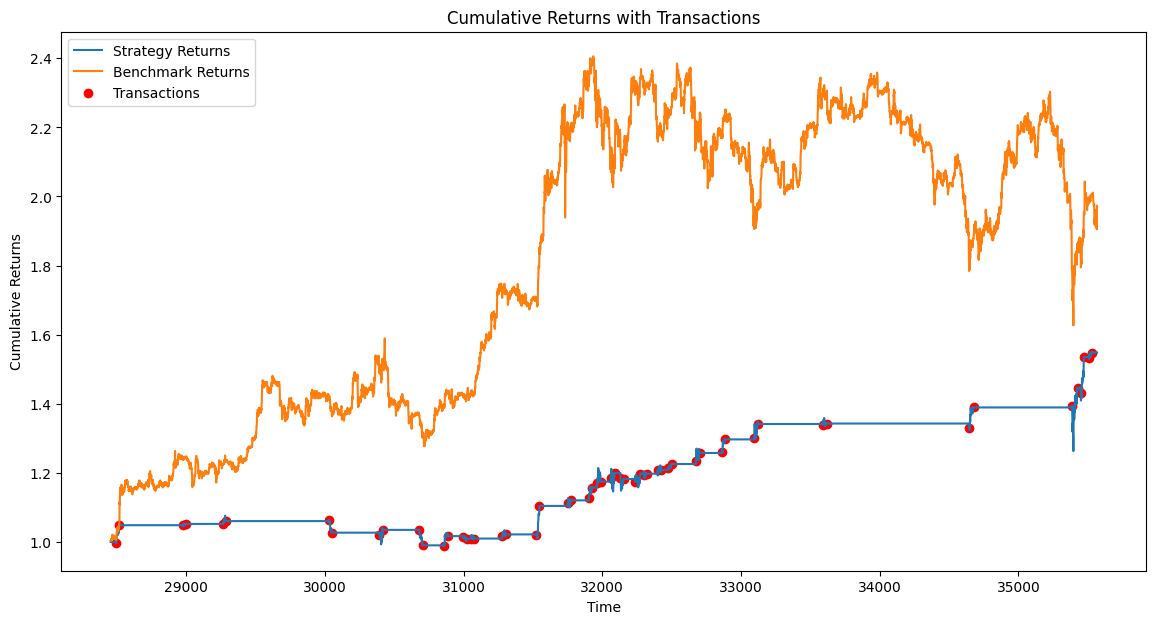

np.float64(0.025160375893963853)

In [274]:
_, X_test, X_train = train_model(data=df_hour, features=combos[idx], target="label", param_grid={}, estimator=DecisionTreeClassifier(random_state=42))

evaluate_model(X_train, models[idx], data=df_hour, signal_threshold=0.55, holding_period=HOLDING_WINDOW, plot=True)
evaluate_model(X_test, models[idx], data=df_hour, signal_threshold=0.55, holding_period=HOLDING_WINDOW, plot=True)

# Single Model Analysis

In [275]:
clf = models[idx]
th = 0.5
sharpe = evaluate_model(X_train, clf, data=df_hour, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000043, std=0.007042
Sharpe BTC 0.00612560868147951
mean=0.000021, std=0.006246
Sharpe Ratio without costs: 0.0033993475409255934
number of transactions 500
mean=0.000012, std=0.006247
Sharpe Ratio with costs: 0.001991706603729881


In [276]:
sharpe = evaluate_model(X_test, clf, data=df_hour, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000049, std=0.004985
Sharpe Ratio without costs: 0.009902740534467772
number of transactions 141
mean=0.000039, std=0.004986
Sharpe Ratio with costs: 0.007910424602290309


In [277]:
from functools import partial

plot_func = partial(evaluate_model, X_test=X_test, best_clf=clf, data=df_hour, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys[i] = plot_func(signal_threshold=xs[i])

mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000049, std=0.004985
Sharpe Ratio without costs: 0.009902740534467772
number of transactions 141
mean=0.000039, std=0.004986
Sharpe Ratio with costs: 0.007910424602290309
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000061, std=0.002285
Sharpe Ratio without costs: 0.026888917736777224
number of transactions 56
mean=0.000058, std=0.002285
Sharpe Ratio with costs: 0.025160375893963853
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000061, std=0.002285
Sharpe Ratio without costs: 0.026888917736777224
number of transactions 56
mean=0.000058, std=0.002285
Sharpe Ratio with costs: 0.025160375893963853
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
mean=0.000061, std=0.002285
Sharpe Ratio without costs: 0.026888917736777224
number of transactions 56
mean=0.000058, std=0.002285
Sharpe Ratio with costs: 0.025160375893963853
mean=0.000095, std=0.005621
Sharpe BTC 0.0169621155058931
m

Text(0, 0.5, 'sharpe')

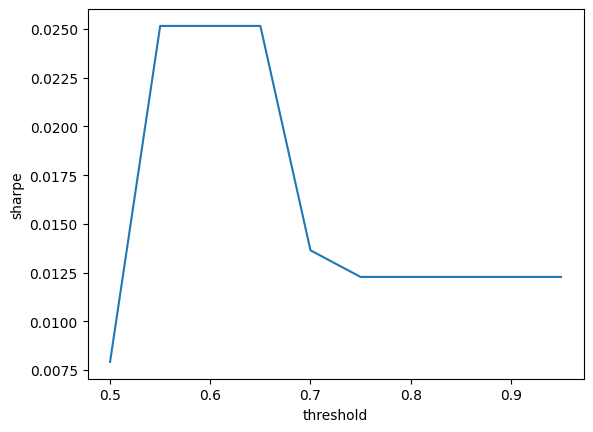

In [278]:
plt.plot(xs, ys)
plt.xlabel("threshold")
plt.ylabel("sharpe")

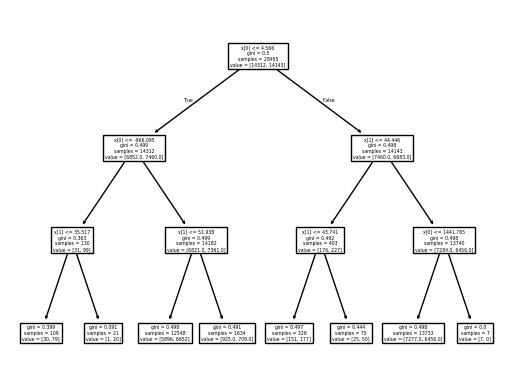

In [280]:
_ = tree.plot_tree(clf)

In [200]:
# Iterate over 3-month periods
start_date = df_hour.index.min()
end_date = df_hour.index.max()

# Create plots for each 3-month period
while start_date < end_date:
    # Define the end date of the current 3-month period
    current_end_date = start_date + pd.DateOffset(months=3)
    
    # Slice the data for the current 3-month period
    df_slice = df_hour[(df_hour.index >= start_date) & (df_hour.index < current_end_date)]
    a = 24*365
    # Plot
    plt.figure(figsize=(16, 6))
    df_slice[["Close", "SMA_500", "SMA_100", "EMA_100", "EMA_500", "SMA_50", "EMA_50", f'SMA_{a}']].plot(ax=plt.gca())
    plt.title(f'Close Price and SMAs from {start_date.date()} to {current_end_date.date()}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()
    
    # Move to the next 3-month period
    start_date = current_end_date

TypeError: unsupported operand type(s) for +: 'int' and 'DateOffset'